In [7]:
import os, sys, time
import numpy as np
import scipy.ndimage, scipy.misc
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
slim = tf.contrib.slim

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1"



def unpickle(file):
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
        return data

def load_cifar10_data(data_dir):
    train_data = None
    train_labels = []
    
    for i in range(1,6):
        data_dic = unpickle(data_dir + "/data_batch_{}".format(i))
        if i==1:
            train_data = data_dic['data']
        else:
            train_data = np.vstack((train_data, data_dic['data']))
        train_labels += data_dic['labels']
    test_data_dic = unpickle(data_dir + "/test_batch")
    test_data = test_data_dic['data']
    test_labels = test_data_dic['labels']
    
    train_data = train_data.reshape((len(train_data), 3, 32, 32))
    train_data = np.rollaxis(train_data, 1, 4)
    train_labels = np.array(train_labels)
    
    test_data = test_data.reshape((len(test_data), 3, 32, 32))
    test_data = np.rollaxis(test_data, 1, 4)
    test_labels = np.array(test_labels)
    
    return train_data, train_labels, test_data, test_labels

data_dir = '/ideaHome/Dropbox/SJ/ML/Cifar10/Data/cifar-10-batches-py'
trImg, train_labels, teImg, test_labels = load_cifar10_data(data_dir)


print("Training data set : %3d, Test data Set : %3d" %(trImg.shape[0], teImg.shape[0]))

Training data set : 50000, Test data Set : 10000


In [8]:
def toLR(image, scale=2.):
    if len(image.shape)==4:
        num_sample = image.shape[0]
        images = np.zeros([image.shape[0], int(image.shape[1]/scale), int(image.shape[2]/scale), image.shape[3]])
        for i in range(num_sample):
            images[i,:,:,:] = scipy.misc.imresize(image[i,:,:,:], 1/scale,'bicubic')
        return images
    else:
        return scipy.misc.imresize(image, 1/scale, 'bicubic')
    

def Bicubic(image, scale=2):
    if len(image.shape)==4:
        bicImg = scipy.ndimage.interpolation.zoom(image, [1, scale, scale, 1], prefilter=False)
    else:
        bicImg = scipy.ndimage.interpolation.zoom(image, [scale,scale,1], prefilter=False)
    return bicImg

def _phase_shift(I, r):
    # Helper function with main phase shift operation
    bsize, a, b, c = I.get_shape().as_list()
    X = tf.reshape(I, (-1, a, b, r, r))
    X = tf.transpose(X, (0, 1, 2, 4, 3))  # bsize, a, b, 1, 1
    X = tf.split(X, a, 1)  # a, [bsize, b, r, r]
    X = tf.concat([tf.squeeze(x) for x in X], axis=2)  # bsize, b, a*r, r
    X = tf.split(X, b, 1)  # b, [bsize, a*r, r]
    X = tf.concat([tf.squeeze(x) for x in X], axis=2)  # bsize, a*r, b*r
    return tf.reshape(X, (-1, a*r, b*r, 1))

def PS(X, r, color=False):
  # Main OP that you can arbitrarily use in you tensorflow code
    if color:
        Xc = tf.split(X,3,3) #(3, 3, X)
        X = tf.concat([_phase_shift(x, r) for x in Xc], axis=3)
    else:
        X = _phase_shift(X, r)
    return X

In [9]:
class SRCNN(object):
    def __init__(self, mode):
        self.LR_dim = (16,16,3)
        self.HR_dim = (32,32,3)
        self.batch_size = 16
        self.mode = mode

        print('The model is generated')
        
    def model(self, img):
        with slim.arg_scope([slim.conv2d], stride=[1,1], activation_fn = tf.nn.relu, padding='SAME',
                                                   weights_initializer=tf.contrib.layers.xavier_initializer()):
            self.layer1 = slim.conv2d(inputs=img, num_outputs=64, kernel_size=[9,9], scope='layer1')
            self.layer2 = slim.conv2d(inputs=self.layer1, num_outputs=32, kernel_size=[1,1], scope='layer2')
            
            if self.mode == 'pixelshuffle':
                self.layer2_5 = slim.conv2d(inputs=self.layer2, num_outputs=12, kernel_size=[5,5], scope='layer', activation_fn=None)
                self.layer3 = PS(self.layer2_5, 2, True)
            else:
                self.layer3 = slim.conv2d(inputs=self.layer2, num_outputs=3, kernel_size=[5,5], scope='layer', activation_fn=None)
                
            out = self.layer3
        return out
    
    def loss(self, SR, HR):
        loss = tf.reduce_mean(tf.square(SR - HR))
        return loss
    
    def build(self):
        if self.mode == 'bicubic':
            self.LRImg = tf.placeholder(tf.float32, [None, 32, 32, 3], 'LRImgBicubic')
        elif self.mode == 'pixelshuffle':
            self.LRImg = tf.placeholder(tf.float32, [None, 16, 16, 3], 'LRImgPixelShuffle')
        else:
            print ('undefined mode')
        self.HRImg = tf.placeholder(tf.float32, [None, 32, 32, 3], 'HRImg')
        self.SRImg = self.model(self.LRImg)
        self.LOSS = self.loss(self.SRImg, self.HRImg)
    
    
    
    

In [10]:
tf.reset_default_graph()
model = SRCNN('pixelshuffle')
model.build()

t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

The model is generated
---------
Variables: name (type shape) [size]
---------
layer1/weights:0 (float32_ref 9x9x3x64) [15552, bytes: 62208]
layer1/biases:0 (float32_ref 64) [64, bytes: 256]
layer2/weights:0 (float32_ref 1x1x64x32) [2048, bytes: 8192]
layer2/biases:0 (float32_ref 32) [32, bytes: 128]
layer/weights:0 (float32_ref 5x5x32x12) [9600, bytes: 38400]
layer/biases:0 (float32_ref 12) [12, bytes: 48]
Total size of variables: 27308
Total bytes of variables: 109232


(27308, 109232)

In [11]:
optm = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(model.LOSS)

In [12]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 
sess.run(tf.global_variables_initializer())

In [16]:
batch_size=16
total_iter = int(trImg.shape[0]/batch_size-1)
for epoch in range(100):
    avg_psnr = 0
    start_time = time.time()
    for batch in range(total_iter):
        LRImg = toLR(trImg[batch:batch + batch_size,:,:,:])
        HRImg = trImg[batch:batch+batch_size,:,:,:]
        _, loss = sess.run([optm, model.LOSS], feed_dict={model.LRImg:LRImg, model.HRImg: HRImg})
        psnr = 20*np.log10(255./np.sqrt(loss))
        avg_psnr+=psnr
        #print "\rIteration: {}/{} ({:.1f}%) psnr: {:.4f}".format(batch, total_iter, batch*100/total_iter, psnr),
        print("\rIteration: {}/{} ({:.2f}%) psnr: {:.4f}".format(batch, total_iter, batch*100/total_iter, psnr), end="")  #Python3
    
    print ('\rEpoch: %3d, avg_PSNR: %.3f, time: %.1f               ' %(epoch+1, avg_psnr/total_iter, time.time() - start_time))

/usr/local/lib/python3.5/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.5/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Epoch:   1, avg_PSNR: 27.089, time: 27.1               
Epoch:   2, avg_PSNR: 27.086, time: 27.3               
Epoch:   3, avg_PSNR: 27.099, time: 27.0               
Epoch:   4, avg_PSNR: 27.094, time: 27.1               
Epoch:   5, avg_PSNR: 27.089, time: 27.0               
Epoch:   6, avg_PSNR: 27.094, time: 27.3               
Epoch:   7, avg_PSNR: 27.104, time: 27.3               
Epoch:   8, avg_PSNR: 27.100, time: 27.3               
Epoch:   9, avg_PSNR: 27.113, time: 26.9               
Epoch:  10, avg_PSNR: 27.106, time: 27.2               
Epoch:  11, avg_PSNR: 27.110, time: 27.2               
Epoch:  12, avg_PSNR: 27.109, time: 27.1               
Epoch:  13, avg_PSNR: 27.113, time: 27.2               
Epoch:  14, avg_PSNR: 27.109, time: 27.1               
Epoch:  15, avg_PSNR: 27.122, time: 27.4               
Epoch:  16, avg_PSNR: 27.121, time: 26.9               
Epoch:  17, avg_PSNR: 27.118, time: 27.0               
Epoch:  18, avg_PSNR: 27.130, time: 27.1        

# Reconstructed Sample Image

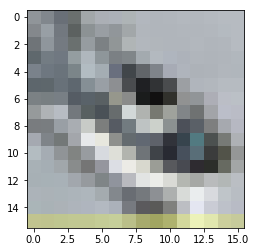

In [39]:
plt.imshow(LRImg[0,:,:,:])

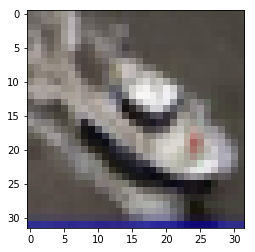

In [40]:
plt.imshow(HRImg[0,:,:,:])

In [19]:
samimg = sess.run(model.layer3, feed_dict={model.LRImg:LRImg[0:2,:,:,:]})

In [20]:
samimg.shape

(2, 32, 32, 3)

In [21]:
LRImg.dtype

dtype('float64')